# LOADING LIBRARIES

In [177]:
# #pip install contractions
# # !pip install -U pip setuptools wheel
# !pip install -U spacy
#!python -m spacy download en_core_web_md
# !pip install bertopic
# !pip install yellowbrick
# !pip install distance

In [28]:
import pandas as pd
import numpy as np
import unicodedata
import re
import contractions
import string
import distance
import glob

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as pgo
from tqdm import tnrange

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = set(stopwords.words('english'))

from bertopic import BERTopic

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOADING THE DATA

In [3]:
def load_data(): 
    df_all = pd.read_csv('Created_Cases - databricks.csv')
    # Take a subset
    return df_all.loc[:, ["Case title","Session Id"]]
df = load_data()
df.rename(
    columns=({ 'Case title': 'Case_title', 'Session Id': 'Session_Id'}), 
    inplace=True,
)
df.head()

Case_title        Session_Id
0                                    genie  1654038670643245
1                                    genie  1654040144291671
2  jproperties library installation issue   1654038759243102
3                          Union with Null  1654032363233406
4   Spark ReadStream fails to infer schema  1654030825979675

In [4]:
#https://www.codegrepper.com/code-examples/python/remove+rows+that+contain+string+pandas
df1 = df[df["Case_title"].str.contains("Genie|genie|Gnie") == False]
df1.reset_index(inplace = True)
del df1['index']
df1

Case_title        Session_Id
0               jproperties library installation issue   1654038759243102
1                                       Union with Null  1654032363233406
2                Spark ReadStream fails to infer schema  1654030825979675
3                   Unable to execute Notebook commands  1654030565271692
4     ARR Customer CVS: Issue - Unable to grant read...  1654029928833435
...                                                 ...               ...
5599  After purging cluster logs, there is no signif...  1646101446712964
5600  Trying to connect MicroStrategy iserver DB con...  1646098742869832
5601             Databricks Shard Upgrade 3.60 Support!  1646098948333606
5602                               Cluster crash weekly  1646096936896602
5603  Security Alert  for connectivity from AWS acco...  1646096681065917

[5604 rows x 2 columns]

In [5]:
df11 = df1.copy()

In [6]:
# len(df)

In [7]:
len(df11)

5604

# KL DIVERGENCE

# 1. Take the Transpose:
I have taken the transpose of my dataset and have applied further steps on the transpose because it is giving somewhat good separable clusters.

In [190]:
# # Transposed_Dataset = df3.T
# Transposed_Dataset.head()

# 2. Scale the Dataset:

Since we will be working on an unsupervised learning model and it works badly on low data.
Hence, there is a need to scale the data before feeding it to the k-means algorithm.

In [191]:
# # Used preprocessing module of sklearn library to scale data.
# X_scaled = preprocessing.scale(Transposed_Dataset)
# len(X_scaled)

# 3. Standardize the Dataset:

In order to ensure internal consistency of the data means each data type will have the same content and format.
Standardized values are useful for tracking data that isn’t easy to compare otherwise.

In [192]:
# X_std = StandardScaler().fit_transform(X_scaled)

# 4. Check uniformity of the Dataset:

I have checked the uniformity of both datasets using the KL divergence test.
I have checked the KL test just for having an idea of distributions, we are not comparing distributions here.
The KL divergence is zero if two distributions are equal.
The KL divergence is positive if two distributions are different.
To find the KL divergence of two datasets, the below function has been used.

In [193]:
# df_variance = df3.var() # Calculating variance for each feature of dataframe
# df_mean = df3.stack().mean() # Calculating mean for each feature of dataframe
# trans_mean = Transposed_Dataset.stack().mean() # Calculating mean for each feature of transpose
# trans_variance = Transposed_Dataset.var() # Calculating variance for each feature of transpose
# df_std = df3.stack().std()   # Calculating standard deviation for each feature of dataframe
# trans_std = Transposed_Dataset.stack().std() # Calculating standard deviation for each feature of transpose
        
# def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [194]:
# from scipy.stats import norm

In [195]:
# def df_normal_dist():
#     x = np.arange(-10, 10, 0.001)
#     dp = norm.pdf(x, df_mean, df_std) 
# #     dq = norm.pdf(x, 0, 1) 
#     # Taking KL divergence b/w Dataframe distribution & normal distribution.
#     plt.title('KL(P||Q) = %1.3f' % kl_divergence(dp, dq))
#     plt.plot(x, dp)
#     plt.plot(x, dq, c='red')
# df_normal_dist()

# Conclusion of applying Uniformity Distribution:

I have first compared plots of each dataset with that of normal distribution because I was getting bell-shaped distributions for each dataset.
From the above graph, one can easily conclude that the dataset is not distributed uniformly since we are getting some bell-shaped curves.
So, we can apply the K-Means algorithm easily.
Once we have checked all the conditions and made the required improvements in the limitations whatsoever, we can move further to apply the K-Means algorithm on our prepared dataset.

# PREPROCESSING OF THE DATA 

In [15]:
df1.head()

Case_title        Session_Id
0            jproperties library installation issue   1654038759243102
1                                    Union with Null  1654032363233406
2             Spark ReadStream fails to infer schema  1654030825979675
3                Unable to execute Notebook commands  1654030565271692
4  ARR Customer CVS: Issue - Unable to grant read...  1654029928833435

In [16]:
# Group by Session_ID
grouped_df = df1.groupby('Session_Id').agg({'Case_title':list})
 
# Join all queries in a cases
grouped_df['Case_title'] = grouped_df['Case_title'].apply(lambda x: ' '.join(x))
 
# Create a list of grouped queries
# for each title. 
queries = list(grouped_df['Case_title'])
queries

['Security Alert  for connectivity from AWS account owned by Databricks',
 'Cluster crash weekly',
 'Trying to connect MicroStrategy iserver DB connection to Databricks',
 'Databricks Shard Upgrade 3.60 Support!',
 'ARR | 2202280060001228 | RCA | Job that was triggered by Data Factory failed due to cluster inactivity  ',
 'After purging cluster logs, there is no significant change in size. What are the other items that constitute the storage?',
 '2201250060001153 2202240030000948',
 'ARR followup - 00132690',
 'Error in data bricks - ConnectException: Connection refused (Connection refused)  Error while obtaining a new communication channel',
 'Integrate Power Apps with Azure Databricks - Connector',
 '2202240030000721001',
 'Remote RPC client disassociated',
 'one AWS account for multiple databricks workspace',
 'SSL error',
 'The spark jobs are taking longer time to start up',
 'Sample case for testing',
 'Issue with notebook execution ',
 'job cluster config change does not take aff

In [21]:
tfidf_vec = TfidfVectorizer(min_df=0.005, 
                            stop_words=nltk.corpus.stopwords.words('english') ) 
data_tfidf = tfidf_vec.fit_transform(queries).todense()
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

In [22]:
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 194
TF-IDF + PCA dimension - 164


# Visualizing more important terms

In [23]:
N_WORDS = 30
mean_data_tfidf = np.array( data_tfidf.mean( axis=0 ) ).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

Text(0.5, 1.0, 'Top-30 most important words')

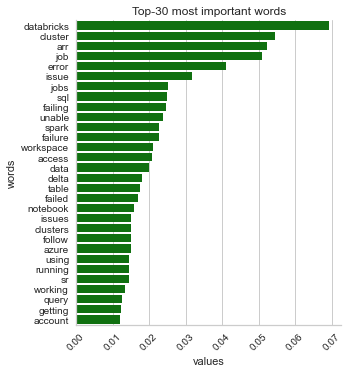

In [24]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

# Clustering with K-means
Selecting number of clusters

In [25]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
  y = kmeans.fit_predict(data_pca)
  score = silhouette_score(data_pca, y)
  cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

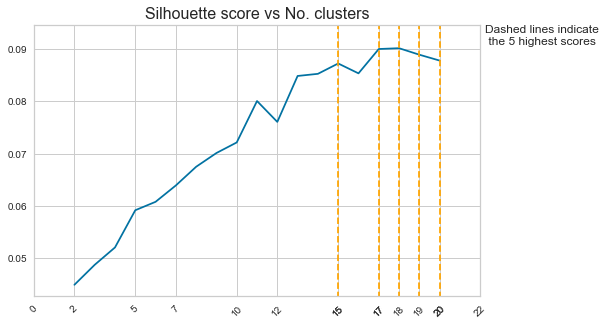

In [26]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

In [27]:
n_clusters=11
kmeans_model = KMeans(n_clusters, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)

# Results visualization
Silhouette samples

In [29]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)


In [30]:
sample_scores_df

index  Cluster  Silhouette
4300   4300        7    0.509948
4968   4968        7    0.509948
3974   3974        7    0.509948
3872   3872        7    0.509948
358     358        7    0.509948
...     ...      ...         ...
4454   4454        6   -0.084096
2195   2195       10   -0.086207
4722   4722       10   -0.090689
1316   1316       10   -0.093844
255     255       10   -0.093844

[5020 rows x 3 columns]

In [33]:
kmeans_pca_scale = KMeans(n_clusters=11, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_pca)

In [34]:
# assign predicted clusters
labels = kmeans_pca_scale.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','Session_Id','Case_title'])
clusters.head(10)

cluster        Session_Id  \
0        5  1646096681065917   
1        4  1646096936896602   
2        3  1646098742869832   
3        3  1646098948333606   
4        1  1646101058033796   
5        4  1646101446712964   
6        8  1646108145921591   
7        7  1646111416608240   
8        6  1646111830399512   
9        3  1646112137174593   

                                          Case_title  
0  Security Alert  for connectivity from AWS acco...  
1                               Cluster crash weekly  
2  Trying to connect MicroStrategy iserver DB con...  
3             Databricks Shard Upgrade 3.60 Support!  
4  ARR | 2202280060001228 | RCA | Job that was tr...  
5  After purging cluster logs, there is no signif...  
6                  2201250060001153 2202240030000948  
7                            ARR followup - 00132690  
8  Error in data bricks - ConnectException: Conne...  
9  Integrate Power Apps with Azure Databricks - C...

In [35]:
clusters['Case_title']  = clusters['Case_title'].astype(str)

In [36]:
clusters.head(10)

cluster        Session_Id  \
0        5  1646096681065917   
1        4  1646096936896602   
2        3  1646098742869832   
3        3  1646098948333606   
4        1  1646101058033796   
5        4  1646101446712964   
6        8  1646108145921591   
7        7  1646111416608240   
8        6  1646111830399512   
9        3  1646112137174593   

                                          Case_title  
0  Security Alert  for connectivity from AWS acco...  
1                               Cluster crash weekly  
2  Trying to connect MicroStrategy iserver DB con...  
3             Databricks Shard Upgrade 3.60 Support!  
4  ARR | 2202280060001228 | RCA | Job that was tr...  
5  After purging cluster logs, there is no signif...  
6                  2201250060001153 2202240030000948  
7                            ARR followup - 00132690  
8  Error in data bricks - ConnectException: Conne...  
9  Integrate Power Apps with Azure Databricks - C...

# BIGRAMS

In [37]:
def find_bigrams(input_list):
    return list(zip(input_list, input_list[1:]))

In [38]:
from nltk import pos_tag, word_tokenize


# What is Dependency Parsing?
Dependency Parsing is the process to analyze the grammatical structure in a sentence and find out related words as well as the type of the relationship between them.

Each relationship:

Has one head and a dependent that modifies the head.
Is labeled according to the nature of the dependency between the head and the dependent. These labels can be found at Universal Dependency Relations.

Simple dependency relation between two words
In the above diagram, there exists a relationship between car and black because black modifies the meaning of car. Here, car acts as the head and black is a dependent of the head. The nature of the relationship here is amod which stands for “Adjectival Modifier”. It is an adjective or an adjective phrase that modifies a noun.

https://towardsdatascience.com/introducing-idea-condensation-5a0c1dbe5cca

In [39]:
# from collections import Counter
# from nltk.tokenize import word_tokenize
 
# my_dict = {}
# n_clusters = clusters['cluster'].unique()
# n=3 
# # for each cluster
# for c in n_clusters: 
#     # 1
#     asset = clusters[clusters['cluster'] == c] 
#     asset = asset['Case_title']
#     m_asset = ' '.join(asset)
#     # 2
#     tokens = word_tokenize(m_asset)
#     # 30
#     words = [word for word in tokens if not word in stops]
#     # 4
#     bigrams = find_bigrams(words)
#     bigrams = list(map(','.join, bigrams))
    
#     bigrams = pos_tag(bigrams)
#     #print(bigrams)
#     print('{:<15} | {:<8} | {:<15} | {:<20}'.format('TOKEN','RELATION','HEAD','CHILDREN'))
#     for (sent,tag) in bigrams:
#         doc = nlp(sent)
#         for token in doc:
#             print("{:<15} | {:<8} | {:<15} | {:<20}"
#             .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))
# #         https://towardsdatascience.com/natural-language-processing-dependency-parsing-cf094bbbe3f7  
#     counts = Counter(word for word,tag in bigrams) #https://www.guru99.com/pos-tagging-chunking-nltk.html
#     most_common = counts.most_common(4)
#     most_freq = ",".join([bigram[0] for bigram in most_common])
#     my_dict[c] = most_freq
     
# # my_dict


# for i,e in enumerate(my_dict.keys()):
#     doc = my_dict[i]
#     displacy.render(docs=nlp(doc),style="dep")
#     print(i)


In [40]:
# # dependency visualization

# # show visualization in Jupyter Notebook
# doc = nlp("this is an example document")
# displacy.render(docs=doc, style='dep', jupyter=True)

# BIGRAM FORMATION WITHIN THE TITLE

In [41]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters['cluster'].unique()
n=3 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters[clusters['cluster'] == c] 
    asset = asset['Case_title']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset)
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{5: 'storage account,Not able,data source,Azure Data',
 4: 'Databricks cluster,start cluster,Cluster terminated.Reason,terminated.Reason :',
 3: 'Azure Databricks,Databricks Databricks,Not able,databricks notebook',
 1: '| Job,Job Failure,Databricks Job,ARR |',
 8: 'delta table,Not able,Delta Live,ARR |',
 7: '[ ARR,ARR ],] [,ARR |',
 6: 'error message,failed error,ARR |,error Error',
 2: 'Databricks workspace,databricks workspace,ARR |,new workspace',
 0: 'jobs failing,Jobs failing,Databricks jobs,failing due',
 9: 'issue Issue,ARR Customer,: Issue,Issue -',
 10: 'Databricks SQL,SQL Endpoint,SQL endpoint,sql endpoint'}

In [42]:
# Add number of article per cluster
val_count = clusters['cluster'].value_counts()
for i in range(len(val_count)):
    my_dict1[i] += f' ({val_count[i]})'

In [43]:
 my_dict1

{5: 'storage account,Not able,data source,Azure Data (247)',
 4: 'Databricks cluster,start cluster,Cluster terminated.Reason,terminated.Reason : (440)',
 3: 'Azure Databricks,Databricks Databricks,Not able,databricks notebook (425)',
 1: '| Job,Job Failure,Databricks Job,ARR | (415)',
 8: 'delta table,Not able,Delta Live,ARR | (1922)',
 7: '[ ARR,ARR ],] [,ARR | (347)',
 6: 'error message,failed error,ARR |,error Error (307)',
 2: 'Databricks workspace,databricks workspace,ARR |,new workspace (196)',
 0: 'jobs failing,Jobs failing,Databricks jobs,failing due (247)',
 9: 'issue Issue,ARR Customer,: Issue,Issue - (245)',
 10: 'Databricks SQL,SQL Endpoint,SQL endpoint,sql endpoint (229)'}

In [44]:
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

In [46]:
#https://stackoverflow.com/questions/43254116/labeling-k-means-cluster-data-points-with-matplotlib

# Use the Clustered Data

In [48]:
show_k = 10
 
print('Cluster number: ', show_k)
print('\nTop bigrams: ')
print(my_dict1[show_k])
print('\nTitles in the cluster: ')
pages = clusters['Case_title'][clusters['cluster'] == show_k]
for page in pages:
    print(page)

Cluster number:  10

Top bigrams: 
Databricks SQL,SQL Endpoint,SQL endpoint,sql endpoint (229)

Titles in the cluster: 
Problem with saving data in table using 9.1 LTS Databricks SQL query error
sql data tab does not show databases
Databricks Table ACL Not Work for SQL Endpoints 
SQL Endpoints Auto stop not working
Unable to Query Delta Table from Databricks SQL
databricks sql error : unable to alter table databricks sql error: Job aborted due to stage failure
How to find the Spark event log in "SQL endpoints"
Timeout for Databricks sql connector for python
Databricks SQL Bug 
[ARR] SR-2203030030001770 Databricks connection issue, when SQL endpoint goes down
SQL Endpoints failed to start
[ARR] SR-2203030030001770 Databricks connection issue, when SQL endpoint goes down
issue with fivetran  destination using sql endpoint 
0239 - g - ARR - RCI - SQL results not expected
Writing to On Premise SQL Server, Extreamly Slow 2203080030000885
EXTREMELY URGENT  -  SQL endpoints failed
Queries on 

# Length wise sorting for each cluster


In [49]:
#Length wise sorting for each cluster
cluster_words_splitted = [word.strip() for word in pages]
#print(sorted(cluster_words_splitted, key=len),end="\n\n")
for page in sorted(cluster_words_splitted, key=len):
    print(page)

SQL
SQL access
SQL access
SQL Endpoint
SQL Endpoint
Spark SQL Failing
Databricks SQL Bug
Databricks SQL api
Databricks SQL API
Get secret via SQL
Library SQL access
sql endpoint issues
Databricks SQL Error
Error on a SQL query.
SQL endpoint failures
SQL Data slow loading
SQL Endpoint 404 Error
sql query hangs forever
SQL option not avaiable
Sql endpoint serverless
SQL access control error
Databricks SQL dashboard
SQL Endpoint not starting
SQL Endpoint Change Owner
SQL endpoint cluster error
dynamic table sames in SQL
Jobs stuck in SQL Endpoint
SQL Endpoints not Starting
losing connection with SQL
SQL joins gives wrong result
SQL joins gives wrong result
SQL Endpoints failed to start
Cannot interact with SQL View
SQL endpoints are not working
SQL endpoint failing to start
Getting Error on SQL End point
SQL Endpoint performance issue
sql endpoint constantly failing
Databricks SQL Dashboard Refresh
Performance tuning spark sql job
SQL Endpoing Unity Catalog Error
Unable to connect to Azur

In [50]:
page

'ARR:PYODBC driver cannot open lib ‘ODBC Driver 17 for SQL server’:file not found(0) while connecting to Azure SQL. Encountered error msg intermittently:SR2205060040003815'

# WORD CLOUD

In [51]:
from wordcloud import WordCloud,STOPWORDS


In [52]:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon',
                      colormap='Pastel1', collocations=False, stopwords = STOPWORDS, ).generate(page)

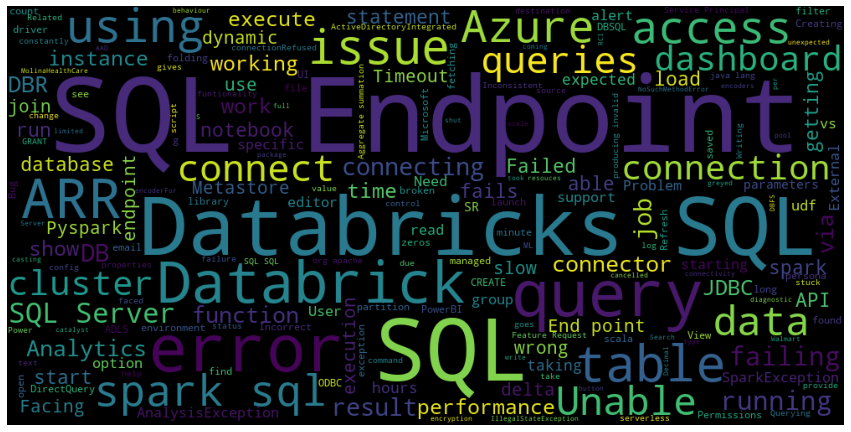

In [53]:
unique_string=(" ").join([page for page in sorted(cluster_words_splitted)])
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()
#please work on https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

# K NEAREST NEIGBHOR

In [55]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(data_tfidf)

NearestNeighbors(n_neighbors=10)

In [57]:
knn.kneighbors(data_tfidf[0:1], return_distance=False)

array([[   0, 3482, 3672, 2245, 1942, 3904, 4529,  471,  434, 2293]])

In [60]:
knn.kneighbors(data_tfidf[0:1], return_distance=True)

(array([[0.        , 0.64394555, 0.7028207 , 0.75092812, 0.77218319,
         0.81320067, 0.81320067, 0.88561239, 0.88561239, 0.88561239]]),
 array([[   0, 3482, 3672, 2245, 1942, 3904, 4529,  471,  434, 2293]]))

In [61]:
input_texts = ['UDF-based External Function not support on SQL Endpoints','Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point']
input_features = vec.transform(input_texts)

D, N = knn.kneighbors(input_features, n_neighbors=2, return_distance=True)

for input_text, distances, neighbors in zip(input_texts, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(clusters['Case_title'][neighbor_idx][:200])
        print("-"*200)
    print("="*200)
    print()

Input text =  UDF-based External Function not support on SQL Endpoints 

Distance =  0.0 Neighbor idx =  3600
UDF-based External Function not support on SQL Endpoints
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.9117507969697021 Neighbor idx =  496
Questions regarding cache in sql endpoints
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Input text =  Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point 

Distance =  0.0 Neighbor idx =  3944
Unable to connect ODBC Simba Spark Connector to Databricks SQL End Point
-----------------------------------------------------------------------------------------------------------------------------------------

In [62]:
input_texts1 = [page for page in (cluster_words_splitted)]
input_features2 = vec.transform(input_texts1)
D, N = knn.kneighbors(input_features2, n_neighbors=5, return_distance=True)

for input_text, distances, neighbors in zip(input_texts1, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(f"Cluster Title \n{clusters['Case_title'][neighbor_idx][:500]}")
        print(f"Cluster No ------- {clusters['cluster'][neighbor_idx]}" )
        print("-"*200)
    print("="*200)
    print()
#https://sanjayasubedi.com.np/nlp/nlp-with-python-nearest-neighbor-search/    

Input text =  Problem with saving data in table using 9.1 LTS Databricks SQL query error 

Distance =  0.0 Neighbor idx =  20
Cluster Title 
Problem with saving data in table using 9.1 LTS Databricks SQL query error
Cluster No ------- 10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.8938471523448068 Neighbor idx =  1734
Cluster Title 
Data is not up-to-date in DBSQL Error messages unclear and not detailed to the problem that actually exists in DBSQL 
Cluster No ------- 5
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.9542101469455317 Neighbor idx =  3256
Cluster Title 
problem overriding an output data
Cluster No ------- 5
--------------------------------

# Show cluster with the most case_title

In [63]:

lst = list(clusters['cluster'])
largest_cluster = max(lst,key=lst.count)
clusters[clusters['cluster'] == largest_cluster]

cluster        Session_Id  \
6           8  1646108145921591   
10          8  1646113362326286   
11          8  1646113535716629   
15          8  1646118412439340   
18          8  1646123108176269   
...       ...               ...   
5012        8  1654019669663687   
5014        8  1654025514210612   
5016        8  1654030565271692   
5017        8  1654030825979675   
5018        8  1654032363233406   

                                             Case_title  
6                     2201250060001153 2202240030000948  
10                                  2202240030000721001  
11                      Remote RPC client disassociated  
15                              Sample case for testing  
18                        follow up ticket for 00133643  
...                                                 ...  
5012                              Disable delta feature  
5014  Create Delta Table Statements Fail Intermittently  
5016                Unable to execute Notebook commands  
5017             Spark ReadStream fails to infer schema  
5018                                    Union with Null  

[1922 rows x 3 columns]

In [248]:
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels_pca_scale, grouped_df.index, queries))
clusters1 = pd.DataFrame(mapping, columns=['cluster','Session_Id','Case_title'])
clusters1.head()

cluster        Session_Id  \
0       16  1646096681065917   
1       23  1646096936896602   
2       16  1646098742869832   
3       16  1646098948333606   
4       19  1646101058033796   

                                          Case_title  
0  Security Alert  for connectivity from AWS acco...  
1                               Cluster crash weekly  
2  Trying to connect MicroStrategy iserver DB con...  
3             Databricks Shard Upgrade 3.60 Support!  
4  ARR | 2202280060001228 | RCA | Job that was tr...

# Topic Modeling using LSI 

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [65]:
svd = TruncatedSVD(
    n_components=10, # default: 10
)

In [67]:
svd.fit(data_tfidf)

TruncatedSVD(n_components=10)

In [68]:
def plot_top_words(model, feature_names, n_top_words=10):
  fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle('SVD', fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

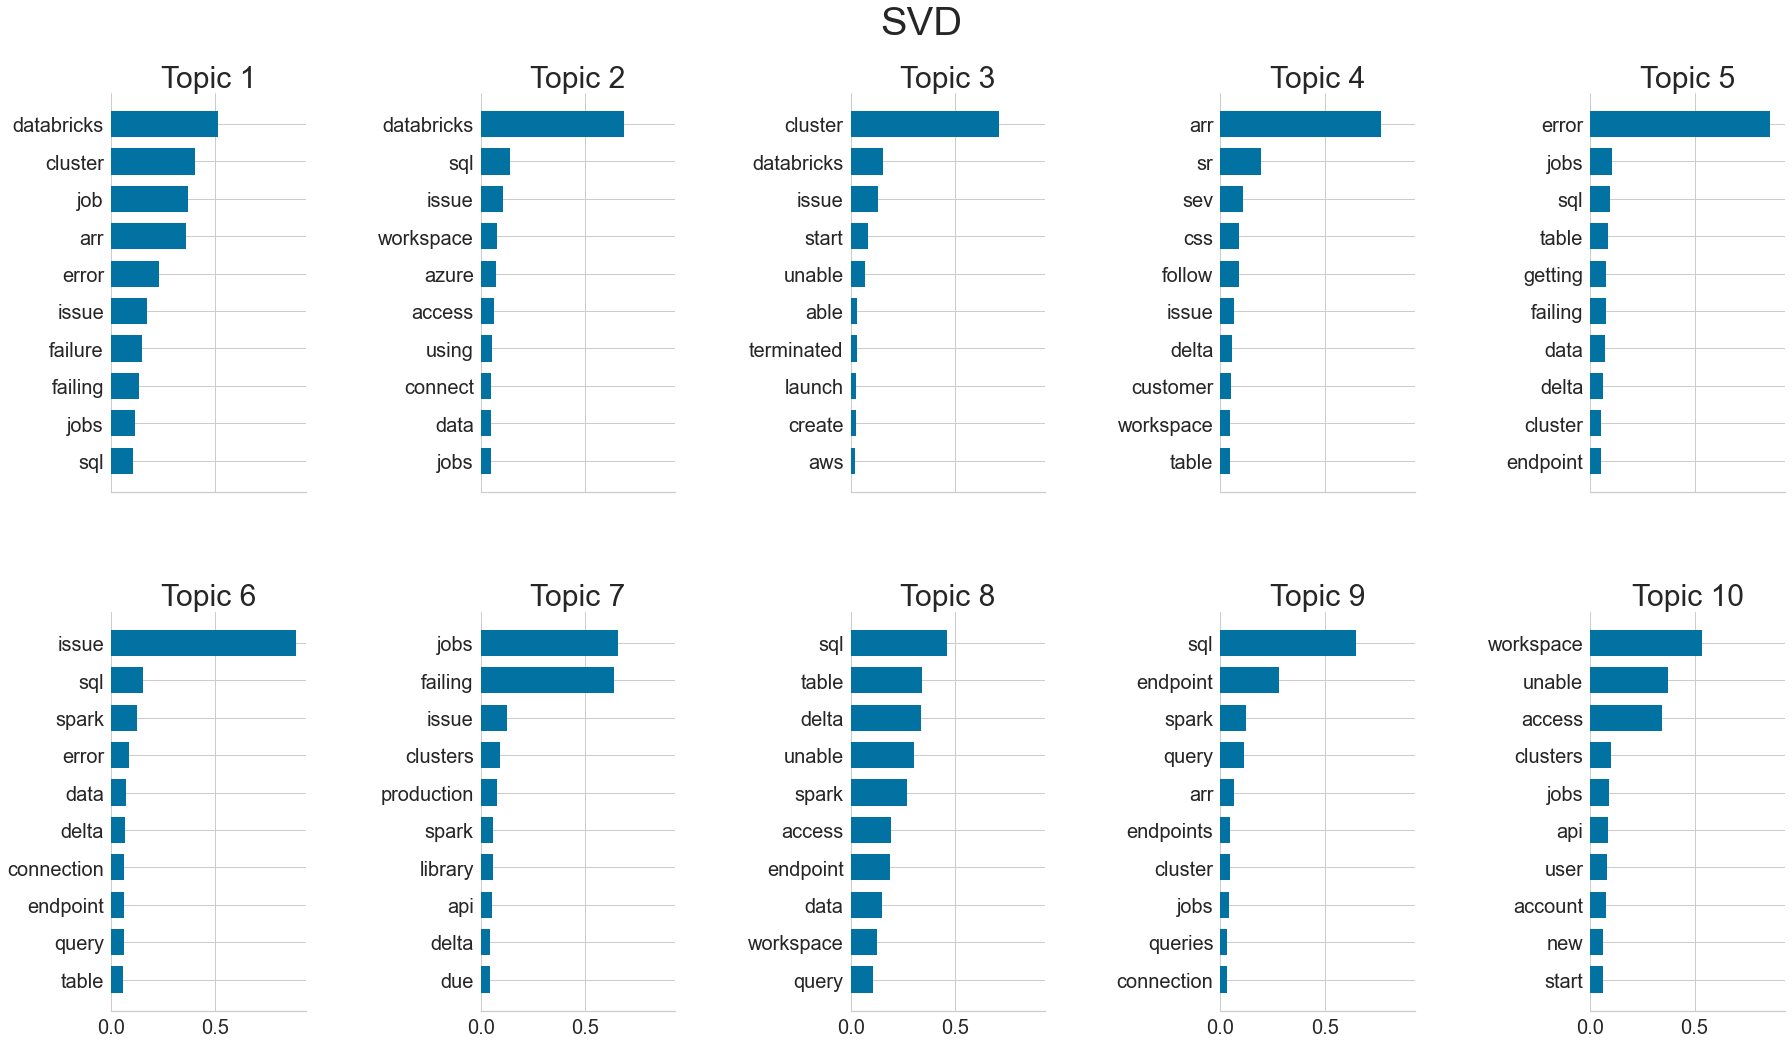

In [69]:
feature_names = vec.get_feature_names()
plot_top_words(svd, feature_names);

In [72]:
Z = svd.transform(data_tfidf)

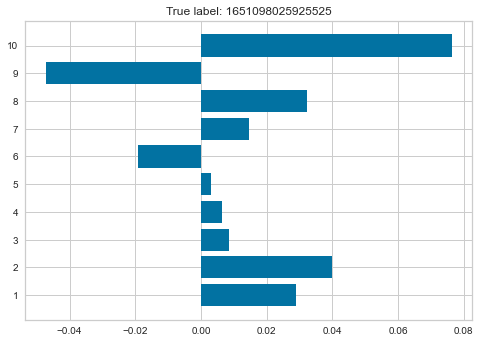

In [73]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['Session_Id']);

# USING BERTopic

In [74]:
type(df1.Case_title)

pandas.core.series.Series

In [75]:
titles = df1.Case_title.to_list()

In [76]:
# Train Model
topic_model = BERTopic(min_topic_size=70, n_gram_range=(1,3), verbose=True)
topics, _ = topic_model.fit_transform(titles)

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

2022-07-02 08:17:52,816 - BERTopic - Transformed documents to Embeddings
2022-07-02 08:18:11,816 - BERTopic - Reduced dimensionality
2022-07-02 08:18:12,087 - BERTopic - Clustered reduced embeddings


In [77]:
freq = topic_model.get_topic_info()
freq.head(10)

Topic  Count                                     Name
0     -1   1896                  -1_to_databricks_for_in
1      0    554              0_cluster_clusters_to_start
2      1    388                    1_job_jobs_failing_to
3      2    378         2_databricks_to_in_in databricks
4      3    324                 3_spark_streaming_job_to
5      4    276   4_genie_access_gennie_2204110040000576
6      5    271        5_sql_endpoint_query_sql endpoint
7      6    250                    6_arr_sev_arr sev_job
8      7    205         7_delta_table_delta table_tables
9      8    146  8_databricks_arr_azure_azure databricks

In [78]:
topic_nr = freq.iloc[6]["Topic"] # select a frequent topic
topic_model.get_topic(topic_nr)

[('sql', 0.06072139441199265),
 ('endpoint', 0.0374434203176945),
 ('query', 0.03743584081169839),
 ('sql endpoint', 0.033321049003677446),
 ('table', 0.024569362354158412),
 ('in', 0.018964793635534914),
 ('dbr', 0.017302575275367327),
 ('error', 0.016213468048500507),
 ('on', 0.016188641627865992),
 ('endpoints', 0.015523700342374281)]

In [79]:
topic_model.visualize_topics()

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [267]:
#https://towardsdatascience.com/dynamic-topic-modeling-with-bertopic-e5857e29f872